<a href="https://colab.research.google.com/github/ChrisW2420/FedDistill/blob/main/knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation

**Author:** [Kenneth Borup](https://twitter.com/Kennethborup)<br>
**Date created:** 2020/09/01<br>
**Last modified:** 2020/09/01<br>
**Description:** Implementation of classical Knowledge Distillation.

## Introduction to Knowledge Distillation

Knowledge Distillation is a procedure for model
compression, in which a small (student) model is trained to match a large pre-trained
(teacher) model. Knowledge is transferred from the teacher model to the student
by minimizing a loss function, aimed at matching softened teacher logits as well as
ground-truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax,
effectively smoothing out the probability distribution and revealing
inter-class relationships learned by the teacher.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

## Setup

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import os
import math
from tensorflow import keras
from keras import layers
from keras import ops
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.interpolate import interp1d

In [3]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from wandb.keras import WandbMetricsLogger

In [ ]:
# configs = dict(
#     num_classes = 10,
#     shuffle_buffer = 1024,
#     batch_size = 64,
#     image_size = 28,
#     image_channels = 1,
#     earlystopping_patience = 3,
#     learning_rate = 1e-3,
#     epochs = 3
# )

## Construct `Distiller()` class

The custom `Distiller()` class, overrides the `Model` methods `compile`, `compute_loss`,
and `call`. In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `compute_loss` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha`
and `1 - alpha`, respectively. Note: only the student weights are updated.

In [6]:
class Distiller(keras.Model):
    def __init__(self, teacher, student, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of teacher with no gradient tracking
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)
            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

## CNN models

In [7]:
# small
def smallCNN():
  smallCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="smallcnn",
  )
  return smallCNN

# medium
def mediumCNN():
  mediumCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return mediumCNN

# big
def bigCNN():
  bigCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="bigcnn",
  )
  return bigCNN

## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
[MNIST](https://keras.io/api/datasets/mnist/), and the procedure would be equivalent for
any other
dataset, e.g. [CIFAR-10](https://keras.io/api/datasets/cifar10/), with a suitable choice
of models. Both the student and teacher are trained on the training set and evaluated on
the test set.

In [8]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Create student and teacher models

In [9]:
def train_CNN(model, _epoch, _name, _proj):
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )
  run = wandb.init(
    reinit=True,
    project = _proj,
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Train and evaluate teacher on data.
  model.fit(x_train, y_train, epochs=_epoch,validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = model.evaluate(x_test, y_test)
  run.finish()
  return model, eval_metrics

def train_distill(_student, _teacher, _epoch, _alpha, _temp, _name, _proj):
  distiller = Distiller(student=_student, teacher=_teacher)
  distiller.compile(
      optimizer=keras.optimizers.Adam(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp,
  )

  run = wandb.init(
    reinit=True,
    project = _proj,
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Distill teacher to student

  distiller.fit(x_train, y_train, epochs=_epoch, validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = distiller.evaluate(x_test, y_test)
  run.finish()
  return distiller, eval_metrics

def cm_plot(model):
  # Preprocess the data
  y_test_cm = to_categorical(y_test, 10)
  # Predict the test set
  predictions = model.predict(x_test)

  # Convert predictions to class labels
  predicted_classes = np.argmax(predictions, axis=1)
  actual_classes = np.argmax(y_test_cm, axis=1)

  # Generate the confusion matrix
  cm = confusion_matrix(actual_classes, predicted_classes)
  cm = (cm/ cm.sum(axis=1))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
  disp.plot()
  plt.show()

  print(cm.diagonal() / cm.sum(axis=1))

# Experiments

## Compare the performance with same student and teacher model


In [ ]:
project = "kdbasicexpr"
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx, m in enumerate(CNNls):
  t_config = m.get_config()
  s_config = m.get_config()
  t_model = keras.models.Sequential.from_config(t_config)
  d_model = keras.models.Sequential.from_config(s_config)
  s_model = keras.models.Sequential.from_config(s_config)
  teacher, teval = train_CNN(t_model, 10, 'teacher'+CNNnames[idx], project)
  distill, deval = train_distill(d_model, teacher, 10, 0.1, 5, 'distill'+CNNnames[idx], project)
  student, seval = train_CNN(s_model, 10, 'rawstu'+CNNnames[idx], project)
  output.append([teval, deval, seval])
  if seval[1] < deval[1]:
    combo.append(CNNnames[idx], CNNnames[idx])
print(output)
print(combo)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6836 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.2837 - val_sparse_categorical_accuracy: 0.9168
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2665 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9538
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9607
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.0968 - val_sparse_categorical_accuracy: 0.9701
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.0762 - val_sparse_categorical_accuracy: 0.9754
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.0721 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▄▃▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▅▆▇▇█████
epoch/val_loss,█▄▃▂▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▅▆▇██████
epoch/epoch,9
epoch/loss,0.06224
epoch/sparse_categorical_accuracy,0.98055
epoch/val_loss,0.06481
epoch/val_sparse_categorical_accuracy,0.979


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.7779 - distillation_loss: 0.2062 - loss: -2.4016 - task_loss: 0.4617 - total_loss: 0.9310 - val_loss: -1.1753 - val_sparse_categorical_accuracy: 0.9268
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9387 - distillation_loss: 0.0707 - loss: -0.5236 - task_loss: 0.1804 - total_loss: 0.3391 - val_loss: 0.5210 - val_sparse_categorical_accuracy: 0.9668
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9665 - distillation_loss: 0.0367 - loss: 0.4310 - task_loss: 0.1084 - total_loss: 0.1894 - val_loss: 0.5049 - val_sparse_categorical_accuracy: 0.9729
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9723 - distillation_loss: 0.0284 - loss: 0.4571 - task_loss: 0.0887 - total_loss: 0.1509 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.9742
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/

epoch/distillation_loss,█▅▂▂▂▂▁▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▇██████▇▇
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,██▅▂▂▃▃▁▂▁
epoch/total_loss,█▆▄▂▂▂▂▁▂▁
epoch/val_loss,▁████▇▇▇▇▆
epoch/val_sparse_categorical_accuracy,▁▆▇▇██████
epoch/distillation_loss,0.01661
epoch/epoch,9
epoch/loss,0.12551


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6956 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.1425 - val_sparse_categorical_accuracy: 0.9568
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9723
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.0824 - val_sparse_categorical_accuracy: 0.9750
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9756
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.0733 - val_sparse_categorical_accuracy: 0.9762
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0666 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/val_loss,█▄▃▃▂▁▂▂▂▁
epoch/val_sparse_categorical_accuracy,▁▆▆▇▇▇▇▇▇█
epoch/epoch,9
epoch/loss,0.06135
epoch/sparse_categorical_accuracy,0.98113
epoch/val_loss,0.06085
epoch/val_sparse_categorical_accuracy,0.9805


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.0852 - val_sparse_categorical_accuracy: 0.9745
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0910 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0627 - val_sparse_categorical_accuracy: 0.9788
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0587 - val_sparse_categorical_accuracy: 0.9799
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0740 - val_sparse_categorical_accuracy: 0.9767
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0516 - val_sparse_categorical_accuracy: 0.9836
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0575 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▃▆▂▃▁▁▂▂
epoch/val_sparse_categorical_accuracy,▁▄▅▂▇▅█▇▇▇
epoch/epoch,9
epoch/loss,0.03775
epoch/sparse_categorical_accuracy,0.98768
epoch/val_loss,0.05405
epoch/val_sparse_categorical_accuracy,0.9836


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.8152 - distillation_loss: 0.1578 - loss: -2.1945 - task_loss: 0.2725 - total_loss: 0.6398 - val_loss: -2.1132 - val_sparse_categorical_accuracy: 0.9746
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9706 - distillation_loss: 0.0447 - loss: -1.9262 - task_loss: 0.0906 - total_loss: 0.1932 - val_loss: -1.6825 - val_sparse_categorical_accuracy: 0.9810
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9787 - distillation_loss: 0.0327 - loss: -1.6441 - task_loss: 0.0670 - total_loss: 0.1420 - val_loss: -1.3000 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9823 - distillation_loss: 0.0267 - loss: -1.4529 - task_loss: 0.0552 - total_loss: 0.1163 - val_loss: -1.3381 - val_sparse_categorical_accuracy: 0.9813
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6

epoch/distillation_loss,█▅▄▄▁▂▂▂▂▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▄▆▆▇▇▇▇██
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,▁▅▅█▁▂▁▁▁▁
epoch/total_loss,▃▆▅█▁▂▁▁▁▁
epoch/val_loss,▁▄▇▆▅▆▇▆▇█
epoch/val_sparse_categorical_accuracy,▁▅▇▅▇▇███▇
epoch/distillation_loss,0.0133
epoch/epoch,9
epoch/loss,-1.20719


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5640 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.1140 - val_sparse_categorical_accuracy: 0.9641
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0720 - val_sparse_categorical_accuracy: 0.9760
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9774
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.0564 - val_sparse_categorical_accuracy: 0.9819
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0512 - val_sparse_categorical_accuracy: 0.9832
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.0490 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▃▂▁▁▂▁▂▂
epoch/val_sparse_categorical_accuracy,▁▅▅▇▇█▇█▇▆
epoch/epoch,9
epoch/loss,0.04216
epoch/sparse_categorical_accuracy,0.98643
epoch/val_loss,0.05813
epoch/val_sparse_categorical_accuracy,0.9804


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.0595 - val_sparse_categorical_accuracy: 0.9800
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0500 - val_sparse_categorical_accuracy: 0.9831
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9874
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9876
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9884
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.0449 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇▇████
epoch/val_loss,█▅▃▁▂▄▅▄▄▅
epoch/val_sparse_categorical_accuracy,▁▄▇▇█▆▆▆▇▅
epoch/epoch,9
epoch/loss,0.01994
epoch/sparse_categorical_accuracy,0.99357
epoch/val_loss,0.04833
epoch/val_sparse_categorical_accuracy,0.985


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.8609 - distillation_loss: 0.1579 - loss: -0.8969 - task_loss: 0.2161 - total_loss: 0.5892 - val_loss: -0.2770 - val_sparse_categorical_accuracy: 0.9780
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9785 - distillation_loss: 0.0463 - loss: -0.4989 - task_loss: 0.0650 - total_loss: 0.1742 - val_loss: -0.6693 - val_sparse_categorical_accuracy: 0.9857
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9860 - distillation_loss: 0.0318 - loss: -0.7136 - task_loss: 0.0446 - total_loss: 0.1197 - val_loss: -0.9297 - val_sparse_categorical_accuracy: 0.9862
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9898 - distillation_loss: 0.0256 - loss: -0.8911 - task_loss: 0.0351 - total_loss: 0.0955 - val_loss: -0.8535 - val_sparse_categorical_accuracy: 0.9874
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 

epoch/distillation_loss,█▃▂▂▂▂▂▂▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▇█▅▃▂▂▂▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/task_loss,█▁▁▁▁▁▂▁▁▁
epoch/total_loss,█▂▁▂▂▁▂▁▁▁
epoch/val_loss,█▅▂▃▃▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▆▆▇▇█▆▆▇▇
epoch/distillation_loss,0.01385
epoch/epoch,9
epoch/loss,-1.12062


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4336 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.0653 - val_sparse_categorical_accuracy: 0.9795
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0545 - val_sparse_categorical_accuracy: 0.9829
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0457 - val_sparse_categorical_accuracy: 0.9847
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9837
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0379 - val_sparse_categorical_accuracy: 0.9877
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0469 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▅▃▅▁▄▁▂▃▄
epoch/val_sparse_categorical_accuracy,▁▄▅▄▇▅█▆▇▆
epoch/epoch,9
epoch/loss,0.01927
epoch/sparse_categorical_accuracy,0.99363
epoch/val_loss,0.04888
epoch/val_sparse_categorical_accuracy,0.986


[[[0.06480518728494644, 0.9789999723434448], [0.08559640496969223, 0.08559640496969223, 0.9793000221252441, 0.08559640496969223, 0.9793000221252441, 0.9793000221252441], [0.06085257604718208, 0.9804999828338623]], [[0.054047711193561554, 0.9836000204086304], [-1.090444564819336, -1.090444564819336, 0.9854000210762024, -1.090444564819336, 0.9854000210762024, 0.9854000210762024], [0.05813028663396835, 0.980400025844574]], [[0.048328299075365067, 0.9850000143051147], [-1.0756947994232178, -1.0756947994232178, 0.9886000156402588, -1.0756947994232178, 0.9886000156402588, 0.9886000156402588], [0.04888257011771202, 0.9860000014305115]]]
[]


## Compare the performance between with and without KD

In [ ]:
project = "basicKDexp2"
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx_t, t in enumerate(CNNls):
  t_config = t.get_config()
  for idx_s ,s in enumerate(CNNls):
    s_config = s.get_config()
    t_model = keras.models.Sequential.from_config(t_config)
    d_model = keras.models.Sequential.from_config(s_config)
    s_model = keras.models.Sequential.from_config(s_config)
    teacher, teval = train_CNN(t_model, 5, 'teacher'+ CNNnames[idx_t], project)
    distill, deval = train_distill(d_model, teacher, 5, 0.1, 5, 'distill'+CNNnames[idx_s], project)
    student, seval = train_CNN(s_model, 5, 'rawstu'+CNNnames[idx_s], project)
    output.append([teval, deval, seval])
    if seval[1] < deval[1]:
      combo.append(CNNnames[idx_t], CNNnames[idx_s])
print(output)
print(combo)


wandb: Currently logged in as: chrisw24 (myfyp). Use `wandb login --relogin` to force relogin


Epoch 1/5
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.8095

wandb: ERROR Unable to log learning rate.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6524 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.1623 - val_sparse_categorical_accuracy: 0.9530
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1172 - val_sparse_categorical_accuracy: 0.9653
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9706
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0928 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0775 - val_sparse_categorical_accuracy: 0.9749
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0764 - val_sparse_categorical_accuracy: 0.9745
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0953 - sparse_categorical_accuracy: 0.9684


epoch/epoch,▁▃▅▆█
epoch/loss,█▃▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇██
epoch/val_loss,█▄▂▁▁
epoch/val_sparse_categorical_accuracy,▁▅▇██
epoch/epoch,4
epoch/loss,0.08132
epoch/sparse_categorical_accuracy,0.9746
epoch/val_loss,0.07642
epoch/val_sparse_categorical_accuracy,0.9745


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.8029 - distillation_loss: 0.1301 - loss: -2.6240 - task_loss: 0.3535 - total_loss: 0.6434 - val_loss: -1.9391 - val_sparse_categorical_accuracy: 0.9604
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - sparse_categorical_accuracy: 0.9594 - distillation_loss: 0.0310 - loss: -1.9562 - task_loss: 0.1210 - total_loss: 0.1863 - val_loss: -1.9232 - val_sparse_categorical_accuracy: 0.9668
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9700 - distillation_loss: 0.0213 - loss: -1.9444 - task_loss: 0.0970 - total_loss: 0.1406 - val_loss: -1.8910 - val_sparse_categorical_accuracy: 0.9743
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9732 - distillation_loss: 0.0175 - loss: -1.8429 - task_loss: 0.0866 - total_loss: 0.1217 - val_loss: -1.6998 - val_sparse_categorical_accuracy: 0.9743
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - spa

epoch/distillation_loss,█▂▁▁▁
epoch/epoch,▁▃▅▆█
epoch/loss,▁▆▇▇█
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/task_loss,▁▄▄█▂
epoch/total_loss,▂▄▄█▁
epoch/val_loss,▁▁▂█▃
epoch/val_sparse_categorical_accuracy,▁▄███
epoch/distillation_loss,0.01668
epoch/epoch,4
epoch/loss,-1.75561


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.1477 - val_sparse_categorical_accuracy: 0.9552
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.1094 - val_sparse_categorical_accuracy: 0.9654
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.0919 - val_sparse_categorical_accuracy: 0.9714
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.0850 - val_sparse_categorical_accuracy: 0.9734
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.0807 - val_sparse_categorical_accuracy: 0.9748
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9682


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▄▂▁▁
epoch/val_sparse_categorical_accuracy,▁▅▇██
epoch/epoch,4
epoch/loss,0.08924
epoch/sparse_categorical_accuracy,0.9734
epoch/val_loss,0.08069
epoch/val_sparse_categorical_accuracy,0.9748


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6616 - sparse_categorical_accuracy: 0.7953 - val_loss: 0.1593 - val_sparse_categorical_accuracy: 0.9508
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1543 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.1088 - val_sparse_categorical_accuracy: 0.9658
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.0831 - val_sparse_categorical_accuracy: 0.9733
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.0772 - val_sparse_categorical_accuracy: 0.9745
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.0717 - val_sparse_categorical_accuracy: 0.9775
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9728


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇███
epoch/val_loss,█▄▂▁▁
epoch/val_sparse_categorical_accuracy,▁▅▇▇█
epoch/epoch,4
epoch/loss,0.08424
epoch/sparse_categorical_accuracy,0.9738
epoch/val_loss,0.07174
epoch/val_sparse_categorical_accuracy,0.9775


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - sparse_categorical_accuracy: 0.8032 - distillation_loss: 0.1060 - loss: -0.2855 - task_loss: 0.2674 - total_loss: 0.5056 - val_loss: -0.1997 - val_sparse_categorical_accuracy: 0.9703
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9717 - distillation_loss: 0.0321 - loss: -0.2353 - task_loss: 0.0849 - total_loss: 0.1568 - val_loss: -0.3469 - val_sparse_categorical_accuracy: 0.9797
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9770 - distillation_loss: 0.0254 - loss: -0.3930 - task_loss: 0.0708 - total_loss: 0.1272 - val_loss: -0.4854 - val_sparse_categorical_accuracy: 0.9819
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9811 - distillation_loss: 0.0218 - loss: -0.4749 - task_loss: 0.0629 - total_loss: 0.1111 - val_loss: -0.5250 - val_sparse_categorical_accuracy: 0.9848
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3m

epoch/distillation_loss,█▄▂▂▁
epoch/epoch,▁▃▅▆█
epoch/loss,██▄▂▁
epoch/sparse_categorical_accuracy,▁▇███
epoch/task_loss,█▂▆▂▁
epoch/total_loss,█▃▄▂▁
epoch/val_loss,█▅▃▂▁
epoch/val_sparse_categorical_accuracy,▁▆▇██
epoch/distillation_loss,0.01409
epoch/epoch,4
epoch/loss,-0.56868


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6065 - sparse_categorical_accuracy: 0.8080 - val_loss: 0.0889 - val_sparse_categorical_accuracy: 0.9719
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0685 - val_sparse_categorical_accuracy: 0.9785
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9828
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0544 - val_sparse_categorical_accuracy: 0.9817
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0454 - val_sparse_categorical_accuracy: 0.9841
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9811


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▁▁▁
epoch/sparse_categorical_accuracy,▁▇███
epoch/val_loss,█▅▂▂▁
epoch/val_sparse_categorical_accuracy,▁▅▇▇█
epoch/epoch,4
epoch/loss,0.05301
epoch/sparse_categorical_accuracy,0.98302
epoch/val_loss,0.04541
epoch/val_sparse_categorical_accuracy,0.9841


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.1632 - val_sparse_categorical_accuracy: 0.9500
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.1032 - val_sparse_categorical_accuracy: 0.9687
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.0930 - val_sparse_categorical_accuracy: 0.9716
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0970 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.0779 - val_sparse_categorical_accuracy: 0.9745
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.0768 - val_sparse_categorical_accuracy: 0.9758
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9700


epoch/epoch,▁▃▅▆█
epoch/loss,█▃▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇██
epoch/val_loss,█▃▂▁▁
epoch/val_sparse_categorical_accuracy,▁▆▇██
epoch/epoch,4
epoch/loss,0.0847
epoch/sparse_categorical_accuracy,0.97385
epoch/val_loss,0.07677
epoch/val_sparse_categorical_accuracy,0.9758


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.8676 - distillation_loss: 0.0646 - loss: -0.0346 - task_loss: 0.1716 - total_loss: 0.3158 - val_loss: -0.2228 - val_sparse_categorical_accuracy: 0.9801
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9806 - distillation_loss: 0.0207 - loss: -0.3452 - task_loss: 0.0612 - total_loss: 0.1069 - val_loss: -0.5259 - val_sparse_categorical_accuracy: 0.9833
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9838 - distillation_loss: 0.0175 - loss: -0.5063 - task_loss: 0.0520 - total_loss: 0.0907 - val_loss: -0.6686 - val_sparse_categorical_accuracy: 0.9848
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9861 - distillation_loss: 0.0153 - loss: -0.6631 - task_loss: 0.0466 - total_loss: 0.0802 - val_loss: -0.7359 - val_sparse_categorical_accuracy: 0.9868
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms

epoch/distillation_loss,█▄▃▃▁
epoch/epoch,▁▃▅▆█
epoch/loss,█▅▃▂▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/task_loss,▃▁█▁▁
epoch/total_loss,▄▁█▁▁
epoch/val_loss,█▄▂▁▃
epoch/val_sparse_categorical_accuracy,▁▄▆█▇
epoch/distillation_loss,0.01048
epoch/epoch,4
epoch/loss,-0.74734


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.0598 - val_sparse_categorical_accuracy: 0.9805
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0659 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0489 - val_sparse_categorical_accuracy: 0.9845
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0464 - val_sparse_categorical_accuracy: 0.9838
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.0554 - val_sparse_categorical_accuracy: 0.9830
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0347 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9873
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9850


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▅▄▇▁
epoch/val_sparse_categorical_accuracy,▁▅▄▄█
epoch/epoch,4
epoch/loss,0.03737
epoch/sparse_categorical_accuracy,0.98802
epoch/val_loss,0.03746
epoch/val_sparse_categorical_accuracy,0.9873


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.0874 - val_sparse_categorical_accuracy: 0.9716
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0994 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0615 - val_sparse_categorical_accuracy: 0.9800
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0741 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0777 - val_sparse_categorical_accuracy: 0.9760
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0656 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0599 - val_sparse_categorical_accuracy: 0.9817
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.0470 - val_sparse_categorical_accuracy: 0.9855
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9826


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▄▆▃▁
epoch/val_sparse_categorical_accuracy,▁▅▃▆█
epoch/epoch,4
epoch/loss,0.05607
epoch/sparse_categorical_accuracy,0.98238
epoch/val_loss,0.04702
epoch/val_sparse_categorical_accuracy,0.9855


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.8057 - distillation_loss: 0.1734 - loss: -2.1691 - task_loss: 0.3642 - total_loss: 0.7614 - val_loss: -1.5146 - val_sparse_categorical_accuracy: 0.9522
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9520 - distillation_loss: 0.0647 - loss: -1.4553 - task_loss: 0.1515 - total_loss: 0.2980 - val_loss: -1.1928 - val_sparse_categorical_accuracy: 0.9646
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9646 - distillation_loss: 0.0463 - loss: -1.3291 - task_loss: 0.1097 - total_loss: 0.2145 - val_loss: -1.1525 - val_sparse_categorical_accuracy: 0.9724
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9698 - distillation_loss: 0.0383 - loss: -1.2677 - task_loss: 0.0920 - total_loss: 0.1786 - val_loss: -1.3052 - val_sparse_categorical_accuracy: 0.9753
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 

epoch/distillation_loss,█▄▃▁▃
epoch/epoch,▁▃▅▆█
epoch/loss,▁▆▇▇█
epoch/sparse_categorical_accuracy,▁▆▇██
epoch/task_loss,▃▁▄█▂
epoch/total_loss,▆▁▄█▂
epoch/val_loss,▁▆▇▄█
epoch/val_sparse_categorical_accuracy,▁▅▇██
epoch/distillation_loss,0.03992
epoch/epoch,4
epoch/loss,-1.16202


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.8046 - val_loss: 0.2064 - val_sparse_categorical_accuracy: 0.9392
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1271 - val_sparse_categorical_accuracy: 0.9607
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.1029 - val_sparse_categorical_accuracy: 0.9688
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.0940 - val_sparse_categorical_accuracy: 0.9693
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0904 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0786 - val_sparse_categorical_accuracy: 0.9745
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9687


epoch/epoch,▁▃▅▆█
epoch/loss,█▃▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇██
epoch/val_loss,█▄▂▂▁
epoch/val_sparse_categorical_accuracy,▁▅▇▇█
epoch/epoch,4
epoch/loss,0.08804
epoch/sparse_categorical_accuracy,0.9737
epoch/val_loss,0.07858
epoch/val_sparse_categorical_accuracy,0.9745


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.8199 - val_loss: 0.0926 - val_sparse_categorical_accuracy: 0.9713
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.0647 - val_sparse_categorical_accuracy: 0.9792
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.0574 - val_sparse_categorical_accuracy: 0.9799
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0497 - val_sparse_categorical_accuracy: 0.9829
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0501 - val_sparse_categorical_accuracy: 0.9819
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9783


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▃▂▁▁
epoch/val_sparse_categorical_accuracy,▁▆▆█▇
epoch/epoch,4
epoch/loss,0.05285
epoch/sparse_categorical_accuracy,0.9832
epoch/val_loss,0.05011
epoch/val_sparse_categorical_accuracy,0.9819


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.8318 - distillation_loss: 0.1138 - loss: -0.8783 - task_loss: 0.2348 - total_loss: 0.4959 - val_loss: -0.9999 - val_sparse_categorical_accuracy: 0.9732
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9733 - distillation_loss: 0.0302 - loss: -1.0169 - task_loss: 0.0786 - total_loss: 0.1463 - val_loss: -0.9558 - val_sparse_categorical_accuracy: 0.9812
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9802 - distillation_loss: 0.0230 - loss: -0.9825 - task_loss: 0.0637 - total_loss: 0.1148 - val_loss: -0.9574 - val_sparse_categorical_accuracy: 0.9830
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9818 - distillation_loss: 0.0197 - loss: -0.8945 - task_loss: 0.0546 - total_loss: 0.0983 - val_loss: -0.8220 - val_sparse_categorical_accuracy: 0.9835
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms

epoch/distillation_loss,▆█▃▄▁
epoch/epoch,▁▃▅▆█
epoch/loss,▁▂▄▆█
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/task_loss,██▁▁▆
epoch/total_loss,██▁▁▅
epoch/val_loss,▁▃▃█▆
epoch/val_sparse_categorical_accuracy,▁▆▇▇█
epoch/distillation_loss,0.01706
epoch/epoch,4
epoch/loss,-0.85192


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5879 - sparse_categorical_accuracy: 0.8172 - val_loss: 0.1017 - val_sparse_categorical_accuracy: 0.9672
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.0678 - val_sparse_categorical_accuracy: 0.9767
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.0691 - val_sparse_categorical_accuracy: 0.9763
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0564 - val_sparse_categorical_accuracy: 0.9820
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.0498 - val_sparse_categorical_accuracy: 0.9841
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9813


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▃▄▂▁
epoch/val_sparse_categorical_accuracy,▁▅▅▇█
epoch/epoch,4
epoch/loss,0.06111
epoch/sparse_categorical_accuracy,0.9804
epoch/val_loss,0.04976
epoch/val_sparse_categorical_accuracy,0.9841


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.5990 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9698
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9757
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0613 - val_sparse_categorical_accuracy: 0.9799
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0585 - val_sparse_categorical_accuracy: 0.9813
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0489 - val_sparse_categorical_accuracy: 0.9840
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9801


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▅▃▂▁
epoch/val_sparse_categorical_accuracy,▁▄▆▇█
epoch/epoch,4
epoch/loss,0.05807
epoch/sparse_categorical_accuracy,0.98142
epoch/val_loss,0.04895
epoch/val_sparse_categorical_accuracy,0.984


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.8620 - distillation_loss: 0.0770 - loss: -0.7544 - task_loss: 0.1767 - total_loss: 0.3516 - val_loss: -0.5747 - val_sparse_categorical_accuracy: 0.9828
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9825 - distillation_loss: 0.0172 - loss: -0.5167 - task_loss: 0.0558 - total_loss: 0.0934 - val_loss: -0.4669 - val_sparse_categorical_accuracy: 0.9864
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - sparse_categorical_accuracy: 0.9861 - distillation_loss: 0.0134 - loss: -0.4292 - task_loss: 0.0455 - total_loss: 0.0744 - val_loss: -0.4801 - val_sparse_categorical_accuracy: 0.9869
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9873 - distillation_loss: 0.0119 - loss: -0.4541 - task_loss: 0.0401 - total_loss: 0.0659 - val_loss: -0.4916 - val_sparse_categorical_accuracy: 0.9875
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms

epoch/distillation_loss,█▃▅▃▁
epoch/epoch,▁▃▅▆█
epoch/loss,▁▆█▇▇
epoch/sparse_categorical_accuracy,▁▇███
epoch/task_loss,▆▁▃▂█
epoch/total_loss,█▁▄▂▄
epoch/val_loss,▁█▇▆▅
epoch/val_sparse_categorical_accuracy,▁▆▇█▇
epoch/distillation_loss,0.00779
epoch/epoch,4
epoch/loss,-0.46576


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3966 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.0629 - val_sparse_categorical_accuracy: 0.9798
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0442 - val_sparse_categorical_accuracy: 0.9854
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0424 - val_sparse_categorical_accuracy: 0.9862
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9889
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0479 - val_sparse_categorical_accuracy: 0.9843
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9800


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▄▃▁▄
epoch/val_sparse_categorical_accuracy,▁▅▆█▄
epoch/epoch,4
epoch/loss,0.03526
epoch/sparse_categorical_accuracy,0.98818
epoch/val_loss,0.04794
epoch/val_sparse_categorical_accuracy,0.9843


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4176 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.0592 - val_sparse_categorical_accuracy: 0.9814
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.0582 - val_sparse_categorical_accuracy: 0.9805
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0492 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0393 - val_sparse_categorical_accuracy: 0.9856
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9881
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9891
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9870


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,██▃▂▁
epoch/val_sparse_categorical_accuracy,▂▁▅▇█
epoch/epoch,4
epoch/loss,0.0342
epoch/sparse_categorical_accuracy,0.98888
epoch/val_loss,0.03334
epoch/val_sparse_categorical_accuracy,0.9891


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.8074 - distillation_loss: 0.2474 - loss: -2.2690 - task_loss: 0.4302 - total_loss: 1.0056 - val_loss: -1.9162 - val_sparse_categorical_accuracy: 0.9432
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9490 - distillation_loss: 0.0918 - loss: -1.7614 - task_loss: 0.1530 - total_loss: 0.3673 - val_loss: -1.2280 - val_sparse_categorical_accuracy: 0.9692
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9676 - distillation_loss: 0.0625 - loss: -1.1099 - task_loss: 0.1032 - total_loss: 0.2491 - val_loss: -0.7929 - val_sparse_categorical_accuracy: 0.9754
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9737 - distillation_loss: 0.0527 - loss: -0.8143 - task_loss: 0.0876 - total_loss: 0.2106 - val_loss: -0.6366 - val_sparse_categorical_accuracy: 0.9772
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3m

epoch/distillation_loss,█▁▁▂▃
epoch/epoch,▁▃▅▆█
epoch/loss,▁▄▇▇█
epoch/sparse_categorical_accuracy,▁▆▇██
epoch/task_loss,█▁▂▂▄
epoch/total_loss,█▁▁▂▄
epoch/val_loss,▁▅▇██
epoch/val_sparse_categorical_accuracy,▁▆███
epoch/distillation_loss,0.06536
epoch/epoch,4
epoch/loss,-0.64874


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.8041 - val_loss: 0.1457 - val_sparse_categorical_accuracy: 0.9556
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.1159 - val_sparse_categorical_accuracy: 0.9628
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.1085 - val_sparse_categorical_accuracy: 0.9659
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0927 - val_sparse_categorical_accuracy: 0.9704
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0991 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.0848 - val_sparse_categorical_accuracy: 0.9742
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1006 - sparse_categorical_accuracy: 0.9684


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▅▄▂▁
epoch/val_sparse_categorical_accuracy,▁▄▅▇█
epoch/epoch,4
epoch/loss,0.09616
epoch/sparse_categorical_accuracy,0.9707
epoch/val_loss,0.08483
epoch/val_sparse_categorical_accuracy,0.9742


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4278 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.0645 - val_sparse_categorical_accuracy: 0.9787
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.0458 - val_sparse_categorical_accuracy: 0.9851
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0590 - val_sparse_categorical_accuracy: 0.9816
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.0446 - val_sparse_categorical_accuracy: 0.9858
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0337 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9842
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9801


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▁▆▁▃
epoch/val_sparse_categorical_accuracy,▁▇▄█▆
epoch/epoch,4
epoch/loss,0.03614
epoch/sparse_categorical_accuracy,0.98875
epoch/val_loss,0.05085
epoch/val_sparse_categorical_accuracy,0.9842


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.7992 - distillation_loss: 0.1650 - loss: -1.3186 - task_loss: 0.2871 - total_loss: 0.6709 - val_loss: -1.3832 - val_sparse_categorical_accuracy: 0.9610
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9670 - distillation_loss: 0.0543 - loss: -1.3658 - task_loss: 0.1016 - total_loss: 0.2272 - val_loss: -1.4071 - val_sparse_categorical_accuracy: 0.9744
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9755 - distillation_loss: 0.0393 - loss: -1.4975 - task_loss: 0.0743 - total_loss: 0.1652 - val_loss: -1.7015 - val_sparse_categorical_accuracy: 0.9819
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9809 - distillation_loss: 0.0317 - loss: -1.5381 - task_loss: 0.0614 - total_loss: 0.1345 - val_loss: -1.4709 - val_sparse_categorical_accuracy: 0.9832
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3m

epoch/distillation_loss,█▄▂▁▁
epoch/epoch,▁▃▅▆█
epoch/loss,▆█▁▃█
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/task_loss,▄▃▁▁█
epoch/total_loss,█▄▁▁▇
epoch/val_loss,▇▆▁▅█
epoch/val_sparse_categorical_accuracy,▁▅▇██
epoch/distillation_loss,0.02431
epoch/epoch,4
epoch/loss,-1.41083


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5950 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.0974 - val_sparse_categorical_accuracy: 0.9687
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.0738 - val_sparse_categorical_accuracy: 0.9754
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0800 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.0581 - val_sparse_categorical_accuracy: 0.9804
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.0535 - val_sparse_categorical_accuracy: 0.9821
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0509 - val_sparse_categorical_accuracy: 0.9833
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9792


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▄▂▁▁
epoch/val_sparse_categorical_accuracy,▁▄▇▇█
epoch/epoch,4
epoch/loss,0.0614
epoch/sparse_categorical_accuracy,0.98008
epoch/val_loss,0.05089
epoch/val_sparse_categorical_accuracy,0.9833


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4246 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.0661 - val_sparse_categorical_accuracy: 0.9784
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0470 - val_sparse_categorical_accuracy: 0.9851
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9841
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9882
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0327 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0403 - val_sparse_categorical_accuracy: 0.9874
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9850


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▃▄▁▂
epoch/val_sparse_categorical_accuracy,▁▆▅█▇
epoch/epoch,4
epoch/loss,0.03383
epoch/sparse_categorical_accuracy,0.98885
epoch/val_loss,0.04034
epoch/val_sparse_categorical_accuracy,0.9874


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - sparse_categorical_accuracy: 0.8693 - distillation_loss: 0.1081 - loss: 0.1074 - task_loss: 0.1799 - total_loss: 0.4322 - val_loss: 0.4014 - val_sparse_categorical_accuracy: 0.9844
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - sparse_categorical_accuracy: 0.9829 - distillation_loss: 0.0239 - loss: 0.2958 - task_loss: 0.0502 - total_loss: 0.1051 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9882
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.9873 - distillation_loss: 0.0166 - loss: 0.0995 - task_loss: 0.0373 - total_loss: 0.0749 - val_loss: 0.0467 - val_sparse_categorical_accuracy: 0.9887
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.9902 - distillation_loss: 0.0135 - loss: -0.0249 - task_loss: 0.0308 - total_loss: 0.0616 - val_loss: -0.1987 - val_sparse_categorical_accuracy: 0.9899
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/st

epoch/distillation_loss,█▄▄▂▁
epoch/epoch,▁▃▅▆█
epoch/loss,█▆▄▂▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/task_loss,▃█▁▁▁
epoch/total_loss,▅█▂▁▁
epoch/val_loss,█▆▄▁▁
epoch/val_sparse_categorical_accuracy,▁▆▆█▇
epoch/distillation_loss,0.00846
epoch/epoch,4
epoch/loss,-0.15256


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4127 - sparse_categorical_accuracy: 0.8747 - val_loss: 0.0691 - val_sparse_categorical_accuracy: 0.9771
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0697 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0447 - val_sparse_categorical_accuracy: 0.9854
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0440 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0413 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.0392 - val_sparse_categorical_accuracy: 0.9880
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9858
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.9820


epoch/epoch,▁▃▅▆█
epoch/loss,█▂▂▁▁
epoch/sparse_categorical_accuracy,▁▇▇██
epoch/val_loss,█▂▂▁▁
epoch/val_sparse_categorical_accuracy,▁▆▆█▇
epoch/epoch,4
epoch/loss,0.03564
epoch/sparse_categorical_accuracy,0.98868
epoch/val_loss,0.04119
epoch/val_sparse_categorical_accuracy,0.9858


[[[0.07642103731632233, 0.9745000004768372], [-1.854628562927246, -1.854628562927246, 0.9743000268936157, -1.854628562927246, 0.9743000268936157, 0.9743000268936157], [0.08068933337926865, 0.9747999906539917]], [[0.07173698395490646, 0.9775000214576721], [-0.5639312267303467, -0.5639312267303467, 0.9846000075340271, -0.5639312267303467, 0.9846000075340271, 0.9846000075340271], [0.04541463777422905, 0.9840999841690063]], [[0.07677433639764786, 0.9757999777793884], [-0.6090778112411499, -0.6090778112411499, 0.9861999750137329, -0.6090778112411499, 0.9861999750137329, 0.9861999750137329], [0.03746407851576805, 0.9872999787330627]], [[0.04702116549015045, 0.9854999780654907], [-1.0621187686920166, -1.0621187686920166, 0.9765999913215637, -1.0621187686920166, 0.9765999913215637, 0.9765999913215637], [0.07857824862003326, 0.9745000004768372]], [[0.05010532960295677, 0.9818999767303467], [-0.866035521030426, -0.866035521030426, 0.9843000173568726, -0.866035521030426, 0.9843000173568726, 0.984

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


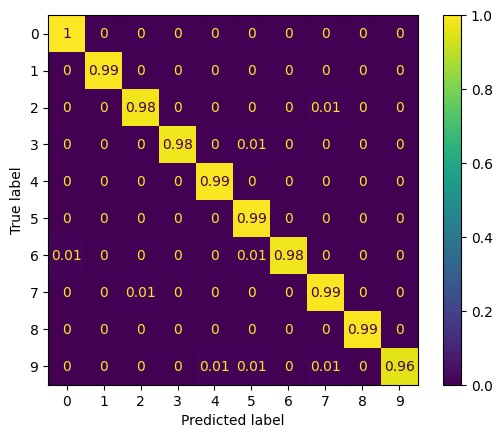

[0.99695665 0.99409003 0.98334669 0.97812723 0.99013456 0.99092707
 0.9784044  0.98549561 0.98563031 0.96361414]


In [ ]:
# ignore for now, code for plotting confusion matrix

# Preprocess the data
y_test_cm = to_categorical(y_test, 10)
# Predict the test set
predictions = teacher.predict(x_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_cm, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
cm = (cm/ cm.sum(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
disp.plot()
plt.show()

print(cm.diagonal() / cm.sum(axis=1))

## observe model weights

In [ ]:
Tweights, Tbiases =  teacher.layers[-1].get_weights()
# Dweights, Dbiases =  distill.call_model().layers[-1].get_weights()
Sweights, Sbiases =  student.layers[-1].get_weights()

print("dimensions of weights:\n", Tweights.shape, Sweights.shape)
print("dimensions of biases:\n", Tbiases.shape, Sbiases.shape)

# print("Weights of the output layer:\n", Tweights, Sweights)
# print("Biases of the output layer:\n", Tbiases, Sbiases)

dimensions of weights:
 (512, 10) (512, 10)
dimensions of biases:
 (10,) (10,)


## Find the most suitable param for each model combimation

### Temperature

In [ ]:
d_model.metrics_names

['loss', 'compile_metrics']

In [ ]:
print(deval)

[-0.7067342400550842, -0.7067342400550842, 0.9757000207901001, -0.7067342400550842, 0.9757000207901001, 0.9757000207901001]


In [ ]:
project = "basicexprtmp1"
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []

t_model = mediumCNN()
teacher, teval = train_CNN(t_model, 10, 'mediumtea', project)
besteval = 0
for i in range(1,15,2):
  d_model = smallCNN()
  distill, deval = train_distill(d_model, teacher, 6, 0.1, 5, 'smallstu tmp'+str(i), project)
  if deval[3] > besteval: #get highest test accuracy
    besteval = deval[3]
    besttmp = i
print(besttmp, besteval)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.8150 - val_loss: 0.0881 - val_sparse_categorical_accuracy: 0.9706
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0891 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0614 - val_sparse_categorical_accuracy: 0.9787
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.0578 - val_sparse_categorical_accuracy: 0.9812
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0520 - val_sparse_categorical_accuracy: 0.9830
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9832
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0469 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▃▂▂▁▂▂▁▂
epoch/val_sparse_categorical_accuracy,▁▅▆▇▇▇▇▇██
epoch/epoch,9
epoch/loss,0.03719
epoch/sparse_categorical_accuracy,0.98815
epoch/val_loss,0.04741
epoch/val_sparse_categorical_accuracy,0.9848


Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.7753 - distillation_loss: 0.2593 - loss: -3.6387 - task_loss: 0.4545 - total_loss: 1.0574 - val_loss: -3.0145 - val_sparse_categorical_accuracy: 0.9414
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9453 - distillation_loss: 0.0997 - loss: -2.6337 - task_loss: 0.1769 - total_loss: 0.4084 - val_loss: -1.9749 - val_sparse_categorical_accuracy: 0.9655
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9616 - distillation_loss: 0.0748 - loss: -1.9134 - task_loss: 0.1309 - total_loss: 0.3049 - val_loss: -1.6072 - val_sparse_categorical_accuracy: 0.9690
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9692 - distillation_loss: 0.0626 - loss: -1.6678 - task_loss: 0.1064 - total_loss: 0.2523 - val_loss: -1.6879 - val_sparse_categorical_accuracy: 0.9732
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sp

epoch/distillation_loss,█▅▃▁▂▁
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▅▇▇██
epoch/sparse_categorical_accuracy,▁▆▇███
epoch/task_loss,▅▄▂▁█▃
epoch/total_loss,█▅▃▁▆▂
epoch/val_loss,▁▆▇▇██
epoch/val_sparse_categorical_accuracy,▁▆▇▇██
epoch/distillation_loss,0.04735
epoch/epoch,5
epoch/loss,-1.3212


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - sparse_categorical_accuracy: 0.7972 - distillation_loss: 0.2671 - loss: -3.3029 - task_loss: 0.4627 - total_loss: 1.0841 - val_loss: -1.7212 - val_sparse_categorical_accuracy: 0.9367
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9375 - distillation_loss: 0.1142 - loss: -1.5857 - task_loss: 0.1910 - total_loss: 0.4573 - val_loss: -0.9834 - val_sparse_categorical_accuracy: 0.9576
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9605 - distillation_loss: 0.0802 - loss: -1.0185 - task_loss: 0.1326 - total_loss: 0.3198 - val_loss: -0.6231 - val_sparse_categorical_accuracy: 0.9701
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9690 - distillation_loss: 0.0641 - loss: -0.6344 - task_loss: 0.1052 - total_loss: 0.2551 - val_loss: -0.5296 - val_sparse_categorical_accuracy: 0.9707
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms

epoch/distillation_loss,█▅▆▂▂▁
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▅▇▇██
epoch/sparse_categorical_accuracy,▁▆▇███
epoch/task_loss,▇▂█▁▃▁
epoch/total_loss,█▄█▂▂▁
epoch/val_loss,▁▅▆▇▇█
epoch/val_sparse_categorical_accuracy,▁▅▇▇██
epoch/distillation_loss,0.03798
epoch/epoch,5
epoch/loss,-0.26741


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.7950 - distillation_loss: 0.2345 - loss: -1.5609 - task_loss: 0.4041 - total_loss: 0.9500 - val_loss: -1.3788 - val_sparse_categorical_accuracy: 0.9488
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9536 - distillation_loss: 0.0860 - loss: -1.5266 - task_loss: 0.1596 - total_loss: 0.3587 - val_loss: -1.7925 - val_sparse_categorical_accuracy: 0.9655
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9659 - distillation_loss: 0.0632 - loss: -1.6633 - task_loss: 0.1163 - total_loss: 0.2626 - val_loss: -1.4640 - val_sparse_categorical_accuracy: 0.9715
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - sparse_categorical_accuracy: 0.9707 - distillation_loss: 0.0531 - loss: -1.6290 - task_loss: 0.0981 - total_loss: 0.2210 - val_loss: -1.4255 - val_sparse_categorical_accuracy: 0.9760
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3m

epoch/distillation_loss,██▁▂▁▅
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▄▃▄▇█
epoch/sparse_categorical_accuracy,▁▆▇███
epoch/task_loss,▇▄▁█▁▃
epoch/total_loss,█▆▁▆▁▄
epoch/val_loss,▆▁▅▆█▇
epoch/val_sparse_categorical_accuracy,▁▅▇███
epoch/distillation_loss,0.0696
epoch/epoch,5
epoch/loss,-1.39463


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.7862 - distillation_loss: 0.2548 - loss: -3.0028 - task_loss: 0.4487 - total_loss: 1.0409 - val_loss: -2.2585 - val_sparse_categorical_accuracy: 0.9429
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9449 - distillation_loss: 0.0990 - loss: -1.9862 - task_loss: 0.1807 - total_loss: 0.4101 - val_loss: -1.4062 - val_sparse_categorical_accuracy: 0.9622
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9645 - distillation_loss: 0.0677 - loss: -1.1090 - task_loss: 0.1248 - total_loss: 0.2815 - val_loss: -0.7948 - val_sparse_categorical_accuracy: 0.9707
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9686 - distillation_loss: 0.0564 - loss: -0.7970 - task_loss: 0.1032 - total_loss: 0.2337 - val_loss: -0.6527 - val_sparse_categorical_accuracy: 0.9725
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/

epoch/distillation_loss,█▂▂▁▁▂
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▅▇███
epoch/sparse_categorical_accuracy,▁▆▇███
epoch/task_loss,█▁▃▂▁▄
epoch/total_loss,█▂▃▁▁▃
epoch/val_loss,▁▅▇██▇
epoch/val_sparse_categorical_accuracy,▁▅▇▇██
epoch/distillation_loss,0.05658
epoch/epoch,5
epoch/loss,-0.74351


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.8027 - distillation_loss: 0.2522 - loss: -3.1895 - task_loss: 0.4406 - total_loss: 1.0272 - val_loss: -2.5096 - val_sparse_categorical_accuracy: 0.9476
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9514 - distillation_loss: 0.0855 - loss: -2.3960 - task_loss: 0.1544 - total_loss: 0.3528 - val_loss: -1.7667 - val_sparse_categorical_accuracy: 0.9673
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9678 - distillation_loss: 0.0603 - loss: -1.8275 - task_loss: 0.1078 - total_loss: 0.2478 - val_loss: -1.5302 - val_sparse_categorical_accuracy: 0.9746
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - sparse_categorical_accuracy: 0.9746 - distillation_loss: 0.0514 - loss: -1.5071 - task_loss: 0.0904 - total_loss: 0.2099 - val_loss: -1.2185 - val_sparse_categorical_accuracy: 0.9762
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 

epoch/distillation_loss,█▄▃▂▁▁
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▅▆▇██
epoch/sparse_categorical_accuracy,▁▇▇███
epoch/task_loss,▆▂█▂▁▁
epoch/total_loss,█▃█▂▁▁
epoch/val_loss,▁▅▆▇▇█
epoch/val_sparse_categorical_accuracy,▁▅▇▇██
epoch/distillation_loss,0.03645
epoch/epoch,5
epoch/loss,-1.0775


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.8191 - distillation_loss: 0.1967 - loss: -1.8145 - task_loss: 0.3235 - total_loss: 0.7829 - val_loss: -1.4431 - val_sparse_categorical_accuracy: 0.9613
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9602 - distillation_loss: 0.0783 - loss: -1.3914 - task_loss: 0.1399 - total_loss: 0.3215 - val_loss: -1.4609 - val_sparse_categorical_accuracy: 0.9666
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9655 - distillation_loss: 0.0693 - loss: -1.3854 - task_loss: 0.1221 - total_loss: 0.2831 - val_loss: -1.3760 - val_sparse_categorical_accuracy: 0.9708
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9692 - distillation_loss: 0.0634 - loss: -1.3622 - task_loss: 0.1089 - total_loss: 0.2566 - val_loss: -1.3666 - val_sparse_categorical_accuracy: 0.9726
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms

epoch/distillation_loss,█▄▃▁▁▂
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▆▇▇██
epoch/sparse_categorical_accuracy,▁▇▇███
epoch/task_loss,▃▁▂█▁▁
epoch/total_loss,▄▂▂█▁▁
epoch/val_loss,▂▁▄▄▃█
epoch/val_sparse_categorical_accuracy,▁▄▅▆▇█
epoch/distillation_loss,0.05403
epoch/epoch,5
epoch/loss,-1.28137


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.8018 - distillation_loss: 0.2194 - loss: -1.0569 - task_loss: 0.3804 - total_loss: 0.8909 - val_loss: -1.0835 - val_sparse_categorical_accuracy: 0.9513
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9492 - distillation_loss: 0.0937 - loss: -1.1245 - task_loss: 0.1781 - total_loss: 0.3945 - val_loss: -1.0294 - val_sparse_categorical_accuracy: 0.9647
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9599 - distillation_loss: 0.0732 - loss: -1.0313 - task_loss: 0.1344 - total_loss: 0.3040 - val_loss: -1.1308 - val_sparse_categorical_accuracy: 0.9683
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9683 - distillation_loss: 0.0588 - loss: -1.0204 - task_loss: 0.1052 - total_loss: 0.2416 - val_loss: -0.7954 - val_sparse_categorical_accuracy: 0.9760
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms

epoch/distillation_loss,▇▆▃█▁▄
epoch/epoch,▁▂▄▅▇█
epoch/loss,▁▃▄▅▆█
epoch/sparse_categorical_accuracy,▁▆▇▇██
epoch/task_loss,▁▂█▁▅▃
epoch/total_loss,▁▂█▂▃▂
epoch/val_loss,▂▃▁▇▄█
epoch/val_sparse_categorical_accuracy,▁▄▅▇▇█
epoch/distillation_loss,0.05767
epoch/epoch,5
epoch/loss,-0.80956


NameError: name 'besttmp' is not defined

# SIMKD

Areas to investigate:

1. implement SIMKD with a new Distiller_simkd class
2. experiment with different size matching methods for the classifier layer: eg. Pooling, Truncation, PCA, extra FC, interpolation eg.

In [10]:
class SimKDDistill(Distiller):
  def __init__(self, teacher, student, matchFunc, alpha=0.1, temperature=3, **kwargs):
      super(SimKDDistill, self).__init__(teacher, student,**kwargs)
      # match classifier weights dimension
      tmp_weights = matchFunc(self.teacher.layers[-1].get_weights()[0], self.student.layers[-1].get_weights()[0])
      # self.teacher.summary()
      # self.student.summary()
      # Assign weights and biases to the last layer, biases are always the same dimension as number of classes
      self.student.layers[-1].set_weights([tmp_weights, self.teacher.layers[-1].get_weights()[1]])

      # Freeze the last layer (prevent it from updating)
      self.student.layers[-1].trainable = False

In [11]:
# Different methods of spatial dimension alignment

def PoolingAlign(input, target):
  n = input.shape[0]
  m = target.shape[0]
  if n==m:
    return input
  # if dimensions are different, average by pooling
  pad_size = m - (n % m)
  padded_tensor = tf.pad(input, [[0, pad_size], [0, 0]])
  new_dim = n + pad_size
  # Mean pooling over batches, reduced in batch size
  output_tensor = tf.reduce_mean(tf.reshape(padded_tensor, [m, new_dim // m, 10]), axis=1)
  return output_tensor

def InterpAlign(input, target):
  n = input.shape[0]
  m = target.shape[0]
  if n==m:
    return input
  # if dimensions are different, interpolate linearly
  x_old = np.arange(n)
  x_new = np.linspace(0, n-1, m)
  f = interp1d(x_old, input, kind='linear', axis=0)
  # New tensor with interpolated data
  output_tensor = f(x_new)
  return output_tensor

In [24]:
# interp

m = 256
n = 512

# Example tensor
tensor = np.random.rand(n, 10)  # Random data for illustration
new_tensor = np.random.rand(m, 10)
new_tensor = InterpAlign(tensor, new_tensor)

print(tensor.shape, new_tensor.shape)

(512, 10) (256, 10)


In [25]:
def train_simKD(_student, _teacher, _matchFunc, _epoch, _alpha, _temp, _name, _proj):
  distiller = SimKDDistill(student=_student, teacher=_teacher, matchFunc=_matchFunc)
  distiller.compile(
      optimizer=keras.optimizers.Adam(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp,
  )

  run = wandb.init(
    reinit=True,
    project = _proj,
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Distill teacher to student

  distiller.fit(x_train, y_train, epochs=_epoch, validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = distiller.evaluate(x_test, y_test)
  run.finish()
  return distiller, eval_metrics

## Compare the performance with same student and teacher model with SimKD

In [ ]:
project = "simkdexp1"
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx, m in enumerate(CNNls):
  t_config = m.get_config()
  s_config = m.get_config()
  t_model = keras.models.Sequential.from_config(t_config)
  d_model = keras.models.Sequential.from_config(s_config)
  dsim_model = keras.models.Sequential.from_config(s_config)
  s_model = keras.models.Sequential.from_config(s_config)
  teacher, teval = train_CNN(t_model, 10, 'teacher'+CNNnames[idx], project)
  distill, deval = train_distill(d_model, teacher, 10, 0.1, 5, 'distill'+CNNnames[idx], project)
  distill_simKD, deval_simKD = train_simKD(dsim_model, teacher, InterpAlign, 10, 0.1, 5, 'simKD'+CNNnames[idx], project)
  student, seval = train_CNN(s_model, 10, 'rawstu'+CNNnames[idx], project)
  output.append([teval, deval, seval])
  if deval_simKD[1] > deval[1]:
    combo.append(CNNnames[idx], CNNnames[idx])
print(combo)

epoch/distillation_loss,█▃▂▁
epoch/epoch,▁▃▆█
epoch/loss,█▄▂▁
epoch/sparse_categorical_accuracy,▁▇██
epoch/task_loss,█▄▁▄
epoch/total_loss,█▃▁▁
epoch/val_loss,█▆▃▁
epoch/val_sparse_categorical_accuracy,▁▇▇█
epoch/distillation_loss,0.00636
epoch/epoch,3
epoch/loss,-0.42417


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6238 - sparse_categorical_accuracy: 0.8118 - val_loss: 0.1496 - val_sparse_categorical_accuracy: 0.9524
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1427 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9682
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1128 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.0902 - val_sparse_categorical_accuracy: 0.9719
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0843 - val_sparse_categorical_accuracy: 0.9724
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0949 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.0938 - val_sparse_categorical_accuracy: 0.9701
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0765 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇▇████
epoch/val_loss,█▄▃▂▃▂▂▁▁▂
epoch/val_sparse_categorical_accuracy,▁▅▆▆▆▇▇██▇
epoch/epoch,9
epoch/loss,0.06696
epoch/sparse_categorical_accuracy,0.97978
epoch/val_loss,0.07577
epoch/val_sparse_categorical_accuracy,0.9748


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - sparse_categorical_accuracy: 0.8131 - distillation_loss: 0.1661 - loss: -2.1206 - task_loss: 0.3755 - total_loss: 0.7532 - val_loss: -1.6825 - val_sparse_categorical_accuracy: 0.9559
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9552 - distillation_loss: 0.0422 - loss: -1.4996 - task_loss: 0.1358 - total_loss: 0.2278 - val_loss: -1.1100 - val_sparse_categorical_accuracy: 0.9675
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9678 - distillation_loss: 0.0283 - loss: -0.9382 - task_loss: 0.1061 - total_loss: 0.1663 - val_loss: -0.7392 - val_sparse_categorical_accuracy: 0.9692
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9712 - distillation_loss: 0.0215 - loss: -0.6863 - task_loss: 0.0891 - total_loss: 0.1340 - val_loss: -0.7741 - val_sparse_categorical_accuracy: 0.9728
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s

epoch/distillation_loss,█▄▃▂▁▁▂▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▅▇███████
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,█▃▂▅▁▃▂▃▅▂
epoch/total_loss,█▄▂▄▁▂▂▂▃▂
epoch/val_loss,▁▅▇▇█▇▇▇▇▇
epoch/val_sparse_categorical_accuracy,▁▄▅▆▇▇▇▇██
epoch/distillation_loss,0.01047
epoch/epoch,9
epoch/loss,-0.74546


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - sparse_categorical_accuracy: 0.7924 - distillation_loss: 0.1399 - loss: -0.7906 - task_loss: 0.2719 - total_loss: 0.5943 - val_loss: -0.9761 - val_sparse_categorical_accuracy: 0.9711
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9734 - distillation_loss: 0.0196 - loss: -0.9555 - task_loss: 0.0856 - total_loss: 0.1260 - val_loss: -0.6460 - val_sparse_categorical_accuracy: 0.9756
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - sparse_categorical_accuracy: 0.9767 - distillation_loss: 0.0143 - loss: -0.8324 - task_loss: 0.0753 - total_loss: 0.1034 - val_loss: -0.9230 - val_sparse_categorical_accuracy: 0.9751
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9783 - distillation_loss: 0.0122 - loss: -0.8883 - task_loss: 0.0716 - total_loss: 0.0948 - val_loss: -0.9294 - val_sparse_categorical_accuracy: 0.9770
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s

epoch/distillation_loss,█▅▂▁▁▂▁▂▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▃▆█▇▅▃▂▁▁▁
epoch/sparse_categorical_accuracy,▁▇████████
epoch/task_loss,▃▃▁█▂▃▁▁▂▃
epoch/total_loss,▄▄▁█▂▃▁▁▂▃
epoch/val_loss,▄█▄▄▄▃▃▃▁▃
epoch/val_sparse_categorical_accuracy,▁▆▅▇▇█▆▅▆▇
epoch/distillation_loss,0.0089
epoch/epoch,9
epoch/loss,-1.04799


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6802 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.1891 - val_sparse_categorical_accuracy: 0.9423
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.1189 - val_sparse_categorical_accuracy: 0.9638
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.0870 - val_sparse_categorical_accuracy: 0.9730
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.0768 - val_sparse_categorical_accuracy: 0.9755
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0861 - val_sparse_categorical_accuracy: 0.9726
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0759 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.0775 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/val_loss,█▄▂▂▂▂▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▅▇▇▇▇████
epoch/epoch,9
epoch/loss,0.06147
epoch/sparse_categorical_accuracy,0.98085
epoch/val_loss,0.06415
epoch/val_sparse_categorical_accuracy,0.98


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6406 - sparse_categorical_accuracy: 0.7871 - val_loss: 0.1207 - val_sparse_categorical_accuracy: 0.9622
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9728
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9763
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9771 - val_loss: 0.0523 - val_sparse_categorical_accuracy: 0.9823
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.0589 - val_sparse_categorical_accuracy: 0.9796
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.0454 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/val_loss,█▄▃▂▂▁▂▂▁▁
epoch/val_sparse_categorical_accuracy,▁▄▅▇▆█▇▇██
epoch/epoch,9
epoch/loss,0.04156
epoch/sparse_categorical_accuracy,0.9865
epoch/val_loss,0.04931
epoch/val_sparse_categorical_accuracy,0.9841


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.7904 - distillation_loss: 0.1649 - loss: -2.5069 - task_loss: 0.2862 - total_loss: 0.6699 - val_loss: -1.7358 - val_sparse_categorical_accuracy: 0.9718
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9704 - distillation_loss: 0.0438 - loss: -1.6604 - task_loss: 0.0865 - total_loss: 0.1872 - val_loss: -1.4902 - val_sparse_categorical_accuracy: 0.9795
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9790 - distillation_loss: 0.0330 - loss: -1.4486 - task_loss: 0.0652 - total_loss: 0.1413 - val_loss: -1.3249 - val_sparse_categorical_accuracy: 0.9820
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9826 - distillation_loss: 0.0280 - loss: -1.2699 - task_loss: 0.0554 - total_loss: 0.1197 - val_loss: -1.0075 - val_sparse_categorical_accuracy: 0.9838
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 

epoch/distillation_loss,█▆▅▄▂▁▃▂▃▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▄▆▆▇█████
epoch/sparse_categorical_accuracy,▁▇▇▇██████
epoch/task_loss,▆▁▅▂▁▅▁▆█▁
epoch/total_loss,█▃▆▃▁▄▂▅█▁
epoch/val_loss,▁▃▄▆▇▇▆█▇▇
epoch/val_sparse_categorical_accuracy,▁▅▆▇▇▇█▆██
epoch/distillation_loss,0.01532
epoch/epoch,9
epoch/loss,-0.88908


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.8656 - distillation_loss: 0.1192 - loss: -2.0014 - task_loss: 0.2026 - total_loss: 0.4804 - val_loss: -2.7194 - val_sparse_categorical_accuracy: 0.9731
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9743 - distillation_loss: 0.0366 - loss: -2.7000 - task_loss: 0.0749 - total_loss: 0.1589 - val_loss: -2.8531 - val_sparse_categorical_accuracy: 0.9794
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9801 - distillation_loss: 0.0288 - loss: -2.7566 - task_loss: 0.0603 - total_loss: 0.1262 - val_loss: -2.6342 - val_sparse_categorical_accuracy: 0.9832
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9830 - distillation_loss: 0.0247 - loss: -2.5957 - task_loss: 0.0527 - total_loss: 0.1093 - val_loss: -2.3755 - val_sparse_categorical_accuracy: 0.9839
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s

epoch/distillation_loss,█▄▃▂▄▁▂▂▂▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▆▁▁▃▆▆▇███
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/task_loss,▃▁▁▅▄▂▁▁█▂
epoch/total_loss,▆▃▂▅▆▂▁▁█▂
epoch/val_loss,▃▁▄▇▇▆▇▇▆█
epoch/val_sparse_categorical_accuracy,▁▄▆▇▇▆▇██▇
epoch/distillation_loss,0.01436
epoch/epoch,9
epoch/loss,-2.28678


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.8239 - val_loss: 0.1042 - val_sparse_categorical_accuracy: 0.9663
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.0617 - val_sparse_categorical_accuracy: 0.9799
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9840
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0610 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.0578 - val_sparse_categorical_accuracy: 0.9799
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0477 - val_sparse_categorical_accuracy: 0.9849
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.0482 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▃▂▃▂▂▁▂▁▂
epoch/val_sparse_categorical_accuracy,▁▆▇▆█▇█▇█▇
epoch/epoch,9
epoch/loss,0.03709
epoch/sparse_categorical_accuracy,0.98813
epoch/val_loss,0.04812
epoch/val_sparse_categorical_accuracy,0.9845


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4183 - sparse_categorical_accuracy: 0.8693 - val_loss: 0.0609 - val_sparse_categorical_accuracy: 0.9800
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0667 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.0446 - val_sparse_categorical_accuracy: 0.9849
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0473 - val_sparse_categorical_accuracy: 0.9846
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9867
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.0328 - val_sparse_categorical_accuracy: 0.9890
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0376 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▅▂▁▂▂▅▄▆
epoch/val_sparse_categorical_accuracy,▁▅▅▆█▇█▆▆▆
epoch/epoch,9
epoch/loss,0.01927
epoch/sparse_categorical_accuracy,0.99358
epoch/val_loss,0.05118
epoch/val_sparse_categorical_accuracy,0.9868


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.8662 - distillation_loss: 0.1579 - loss: -2.3045 - task_loss: 0.2263 - total_loss: 0.5984 - val_loss: -1.8578 - val_sparse_categorical_accuracy: 0.9795
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9801 - distillation_loss: 0.0453 - loss: -1.5931 - task_loss: 0.0716 - total_loss: 0.1776 - val_loss: -1.4140 - val_sparse_categorical_accuracy: 0.9847
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9860 - distillation_loss: 0.0319 - loss: -1.3482 - task_loss: 0.0489 - total_loss: 0.1238 - val_loss: -1.1599 - val_sparse_categorical_accuracy: 0.9843
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9883 - distillation_loss: 0.0255 - loss: -1.2505 - task_loss: 0.0385 - total_loss: 0.0983 - val_loss: -1.2292 - val_sparse_categorical_accuracy: 0.9881
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7

epoch/distillation_loss,█▃▄▃▂▂▁▂▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▅▇▇███▇▇▇
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,▃▄▂█▃▁▁▂▄▁
epoch/total_loss,█▄▅▆▃▂▁▂▃▁
epoch/val_loss,▁▅█▇▇▇█▆▅▆
epoch/val_sparse_categorical_accuracy,▁▅▅▇▇█▇██▇
epoch/distillation_loss,0.01234
epoch/epoch,9
epoch/loss,-1.32105


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.9167 - distillation_loss: 0.1092 - loss: -1.7886 - task_loss: 0.1458 - total_loss: 0.4042 - val_loss: -1.9351 - val_sparse_categorical_accuracy: 0.9853
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9851 - distillation_loss: 0.0318 - loss: -2.0101 - task_loss: 0.0520 - total_loss: 0.1264 - val_loss: -2.0666 - val_sparse_categorical_accuracy: 0.9837
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - sparse_categorical_accuracy: 0.9884 - distillation_loss: 0.0228 - loss: -2.0811 - task_loss: 0.0362 - total_loss: 0.0896 - val_loss: -2.1051 - val_sparse_categorical_accuracy: 0.9875
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9908 - distillation_loss: 0.0187 - loss: -2.0760 - task_loss: 0.0289 - total_loss: 0.0728 - val_loss: -2.1774 - val_sparse_categorical_accuracy: 0.9867
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 

epoch/distillation_loss,█▅▄▄▂▂▃▃▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▂▁▁▁▂▃▅▅▅
epoch/sparse_categorical_accuracy,▁▆▆▇▇▇████
epoch/task_loss,▃▁▅▆▁▁█▁▂▁
epoch/total_loss,▆▄▆▇▁▂█▂▂▁
epoch/val_loss,▇▄▃▁▂▇▂█▆▅
epoch/val_sparse_categorical_accuracy,▃▁▆▅█▇▆▆▇▇
epoch/distillation_loss,0.00697
epoch/epoch,9
epoch/loss,-1.95651


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4059 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.0652 - val_sparse_categorical_accuracy: 0.9789
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.0442 - val_sparse_categorical_accuracy: 0.9851
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0418 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0415 - val_sparse_categorical_accuracy: 0.9866
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.0367 - val_sparse_categorical_accuracy: 0.9874
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.0583 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▂▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▃▂▂▁▆▂▂▃▆
epoch/val_sparse_categorical_accuracy,▁▆▆▇█▄███▆
epoch/epoch,9
epoch/loss,0.01836
epoch/sparse_categorical_accuracy,0.99368
epoch/val_loss,0.05672
epoch/val_sparse_categorical_accuracy,0.985


[]


this shows simkd applied on identical teacher/student models show great performance improvement on

## Compare the performance for different teacher and student model using FC alignment

In [26]:
# show that the dimension alignment method works
project = "simkdexp2"
t_model = mediumCNN()
dsimpool_model = smallCNN()
dsiminter_model = smallCNN()
d_model = smallCNN()
s_model = smallCNN()

teacher, teval = train_CNN(t_model, 10, 'Mteacher', project)
distill_simPool, deval_simPool = train_simKD(dsimpool_model, teacher, PoolingAlign, 10, 0.1, 5, 'SsimKD+Pool', project)
distill_simInterp, deval_simInterp = train_simKD(dsiminter_model, teacher, InterpAlign, 10, 0.1, 5, 'SsimKD+Interp', project)
distill, deval = train_distill(d_model, teacher, 10, 0.1, 5, 'Sdistill', project)
student, seval = train_CNN(s_model, 10, 'Srawstu', project)

print(teval[1], deval_simPool[1], deval_simInterp[1], deval[1], seval[1])

wandb: Currently logged in as: chrisw24 (myfyp). Use `wandb login --relogin` to force relogin


Epoch 1/10
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4296 - sparse_categorical_accuracy: 0.8618

wandb: ERROR Unable to log learning rate.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4281 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.0737 - val_sparse_categorical_accuracy: 0.9757
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0452 - val_sparse_categorical_accuracy: 0.9859
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0416 - val_sparse_categorical_accuracy: 0.9861
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0392 - val_sparse_categorical_accuracy: 0.9879
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9876
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0468 - val_sparse_categorical_accuracy: 0.9860
Ep

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▂▁▁▁▃▁▂▂▂
epoch/val_sparse_categorical_accuracy,▁▇▇██▇▇█▇█
epoch/epoch,9
epoch/loss,0.01715
epoch/sparse_categorical_accuracy,0.99437
epoch/val_loss,0.04395
epoch/val_sparse_categorical_accuracy,0.9877


Model: "bigcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,840 (280.63 KB)

 Trainable params: 23,946 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,894 (187.09 KB)

Model: "mediumcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,138 (23.98 KB)

 Trainable params: 6,138 (23.98 KB)

 Non-trainable params: 0 (0.00 B)

(256, 10) <class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'> (256, 10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.7413 - distillation_loss: 0.3961 - loss: 0.7803 - task_loss: 0.5367 - total_loss: 1.4732 - val_loss: 1.6903 - val_sparse_categorical_accuracy: 0.9375
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9375 - distillation_loss: 0.1553 - loss: 1.5019 - task_loss: 0.2381 - total_loss: 0.6026 - val_loss: 1.2954 - val_sparse_categorical_accuracy: 0.9595
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9574 - distillation_loss: 0.1174 - loss: 1.2495 - task_loss: 0.1716 - total_loss: 0.4480 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.9688
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - sparse_categorical_accuracy: 0.9638 - distillation_loss: 0.1005 - loss: 1.0212 - task_loss: 0.1417 - total_loss: 0.3789 - val_loss: 1.0474 - val_sparse_categorical_accuracy: 0.9715
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - spars

epoch/distillation_loss,█▄▃▃▃▃▂▁▁▂
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▆█▆▅▄▃▂▂▂▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/task_loss,█▂▂▁▄▆▅▆▁▃
epoch/total_loss,█▃▂▂▄▄▃▄▁▃
epoch/val_loss,█▆▄▅▃▂▃▂▁▁
epoch/val_sparse_categorical_accuracy,▁▅▆▇▇█████
epoch/distillation_loss,0.08164
epoch/epoch,9
epoch/loss,0.43494


Model: "bigcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,840 (280.63 KB)

 Trainable params: 23,946 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,894 (187.09 KB)

Model: "mediumcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,138 (23.98 KB)

 Trainable params: 6,138 (23.98 KB)

 Non-trainable params: 0 (0.00 B)

(256, 10) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (256, 10)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - sparse_categorical_accuracy: 0.8297 - distillation_loss: 0.2362 - loss: -1.7083 - task_loss: 0.2879 - total_loss: 0.8495 - val_loss: -2.4741 - val_sparse_categorical_accuracy: 0.9690
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - sparse_categorical_accuracy: 0.9689 - distillation_loss: 0.0831 - loss: -2.4007 - task_loss: 0.1148 - total_loss: 0.3111 - val_loss: -2.8698 - val_sparse_categorical_accuracy: 0.9780
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9769 - distillation_loss: 0.0648 - loss: -3.0892 - task_loss: 0.0862 - total_loss: 0.2397 - val_loss: -3.1789 - val_sparse_categorical_accuracy: 0.9822
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.9806 - distillation_loss: 0.0546 - loss: -3.3402 - task_loss: 0.0720 - total_loss: 0.2014 - val_loss: -3.6039 - val_sparse_categorical_accuracy: 0.9832
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 

epoch/distillation_loss,▇█▃▂▂▃▂▂▂▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▅▃▁▁▁▂▂▃▃
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,▅█▂▁▁▃▁▁▁▁
epoch/total_loss,▅█▂▁▁▃▁▁▁▁
epoch/val_loss,█▆▄▁▂▃▄▃▄▅
epoch/val_sparse_categorical_accuracy,▁▄▆▆▆▇████
epoch/distillation_loss,0.02599
epoch/epoch,9
epoch/loss,-3.10031


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - sparse_categorical_accuracy: 0.8056 - distillation_loss: 0.2541 - loss: -0.2783 - task_loss: 0.3366 - total_loss: 0.9382 - val_loss: -0.2927 - val_sparse_categorical_accuracy: 0.9684
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9654 - distillation_loss: 0.0827 - loss: -0.2328 - task_loss: 0.1213 - total_loss: 0.3158 - val_loss: -0.3385 - val_sparse_categorical_accuracy: 0.9785
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9766 - distillation_loss: 0.0628 - loss: -0.3978 - task_loss: 0.0865 - total_loss: 0.2348 - val_loss: -0.2580 - val_sparse_categorical_accuracy: 0.9813
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9793 - distillation_loss: 0.0526 - loss: -0.5294 - task_loss: 0.0713 - total_loss: 0.1956 - val_loss: -0.6101 - val_sparse_categorical_accuracy: 0.9834
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━

epoch/distillation_loss,█▄▃▂▂▃▂▂▂▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,██▆▅▄▃▂▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/task_loss,█▄▁▁▁▁▁▁▁▁
epoch/total_loss,█▄▂▁▁▂▁▁▁▁
epoch/val_loss,█▇█▅▄▄▄▁▂▂
epoch/val_sparse_categorical_accuracy,▁▅▆▇██▇█▇█
epoch/distillation_loss,0.02093
epoch/epoch,9
epoch/loss,-0.87979


NameError: name 'CNNnames' is not defined

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.1245 - val_sparse_categorical_accuracy: 0.9614
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.0660 - val_sparse_categorical_accuracy: 0.9770
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0578 - val_sparse_categorical_accuracy: 0.9810
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0694 - val_sparse_categorical_accuracy: 0.9783
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0568 - val_sparse_categorical_accuracy: 0.9817
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0527 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▃▂▃▂▂▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇█
epoch/epoch,9
epoch/loss,0.03882
epoch/sparse_categorical_accuracy,0.9877
epoch/val_loss,0.04599
epoch/val_sparse_categorical_accuracy,0.9866


0.9876999855041504 0.40635359287261963 -2.9942729473114014 -0.8880013823509216 0.9865999817848206


# Adaptive alpha

The ratio between the classfication loss and divergence loss can be changed over the training process upon different criterion:

- how good the teacher is
- how fast the training needs to be
- capacity gap

develop an algorithm that automatically find

NB. already exists in Tsinghua paper

# EMNIST

https://github.com/wandb/awesome-dl-projects/blob/master/ml-tutorial/Investigating_EMNIST.ipynb

In [ ]:
import tensorflow_datasets as tfds
from tqdm import tqdm

In [ ]:
wandb.init(entity='iit-bhu', project='investigate-emnist')

epoch,▁▃▅▆█▁▃▅▁▃▅
loss,▆▂▂▂▂▂▁▁█▃▃
s_eval_accuracy,▁
s_eval_loss,▁
ss_eval_accuracy,▁
ss_eval_loss,▁
t_eval_accuracy,▁
t_eval_loss,▁
epoch,2
loss,0.10009
s_eval_accuracy,0.973


In [ ]:
(train_ds, validation_ds) = tfds.load(
    "emnist/byclass",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True

)

builder = tfds.builder('emnist/bymerge')
builder.info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

NonMatchingChecksumError: Artifact https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip, downloaded to /root/tensorflow_datasets/downloads/itl.nist.gov_iaui_vip_cs_links_EMNIST_gzipi4VnNviDSrfd9Zju6qv40flc3wr22t8ldulNStS6tmk.zip.tmp.c76a8d8c76884eec8b42e98ab3a5d3e1/itl, has wrong checksum:
* Expected: UrlInfo(size=535.73 MiB, checksum='fb9bb67e33772a9cc0b895e4ecf36d2cf35be8b709693c3564cea2a019fcda8e', filename='gzip.zip')
* Got: UrlInfo(size=108.59 KiB, checksum='f50e850b1a77c59d1322807a84d3bd201ed58c665dfd333ddd43c841c9899294', filename='itl')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror